## 라이브러리/데이터 불러오기

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install pathlib
!pip install datetime
!pip install parse
!pip install sklearn
!pip install mlxtend --upgrade --no-deps
!pip install xgboost
!pip install pyswarm
!pip install GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 KB 9.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=101bd8aace4626fa77c77

In [2]:
import numpy as np
from numpy import mean
import pandas as pd
import argparse
from parse import compile
from pathlib import Path
from datetime import date
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from mlxtend.frequent_patterns import fpgrowth
import xgboost
from xgboost import plot_importance
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyswarm import pso
import GPUtil
warnings.simplefilter("ignore")

In [3]:
df_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/U-WURF/raw_data.csv")

In [4]:
df_raw.head()

,EQUIP_ID,MFG_DT,SALE_CD,MOLD_POS,REAL_POWER,CP,AX,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5
0,EQUIP1,2021-03-23,SALES 0,8,0.00,NaN,NaN,CORE1 A 02. 0570,CORE1 A 01. P3+3,CORE1 A 05. M0075,CORE1 A 8A. D-00,-6.4889,6.5811,0.00,0.12,0.12,0.12,0.25,0.25
1,EQUIP2,2021-03-23,SALES 1,1,-6.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,-6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50
2,EQUIP1,2021-03-25,SALES 2,2,0.00,NaN,NaN,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0000,CORE2 C 04. A-00,-7.3246,7.3802,0.00,0.12,0.12,0.25,0.25,0.25
3,EQUIP2,2021-03-25,SALES 3,6,-7.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,-6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62
4,EQUIP3,2021-04-09,SALES 4,1,-0.75,NaN,NaN,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,-7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87


## 데이터 전처리

In [5]:
CORES = ["MOLD_IN_TOP", "MOLD_IN_BOT", "MOLD_OUT_TOP" , "MOLD_OUT_BOT"]
RADIUS = ["IN_RADIUS", "OUT_RADIUS"]
EQUIP_INFO = ["EQUIP_ID", "MOLD_POS"]
POWERS = ["POWER1", "POWER2", "POWER3", "POWER4", "POWER5"]

In [6]:
# 렌즈 분류 및 카테고리 추가
df_raw["CATEGORY"] = "MYOPIA"
df_raw["CATEGORY"][df_raw["REAL_POWER"] == 0] = "BEAUTY"
df_raw["CATEGORY"][df_raw["REAL_POWER"] > 0] = "HYPER"

In [7]:
# 누락 데이터 처리
def preprocessing_missing(df_before):
  type = 'Missing Value'
  print(f"Type of preprocessing: {type}")
  print(f"The shape of data before preprocessing: {df_before.shape}")

  tmp = np.where((df_before.values == "NULL")|(df_before.values == ''), np.NaN, df_before.values)
  df_after = pd.DataFrame(data=tmp, columns=df_before.columns)
  df_after = df_after.dropna(how='any', subset=CORES+RADIUS)

  print(f"The shape of data after preprocessing: {df_after.shape}\n")

  return df_after

In [8]:
# 데이터 형변환 처리 -> 열 이름 대문자 통일, 형 통일, 절댓값 수정
def preprocessing_conversion(df_before):

 type = "Data Type Conversion"
 print(f"Type of preprocessing: {type}")
 print(f"The shape of data before preprocessing: {df_before.shape}")

 # 컬럼명을 모두 대문자로 변환
 df_before.columns = [col.upper() for col in df_before.columns]
 print(df_before.columns)

 # 컬럼의 데이터형 통일
 col_type = {'MOLD_POS' : 'int',
  "REAL_POWER":"float32",
  "OUT_RADIUS":"float32",
  "IN_RADIUS":"float32",
  "POWER":"float32",
  "POWER1":"float32",
  "POWER2":"float32",
  "POWER3":"float32",
  "POWER4":"float32",
  "POWER5":"float32"}
 
 df_after = df_before.astype(col_type)
 df_after["MFG_DT"] = pd.to_datetime(df_before["MFG_DT"])
 
 # IN_RADIUS와 OUT_RADIUS의 값의 부호 삭제
 df_after["IN_RADIUS"] = abs(df_after["IN_RADIUS"])
 df_after["OUT_RADIUS"] = abs(df_after["OUT_RADIUS"])

 # CORES 대문자로 변환
 df_after[CORES] = df_after[CORES].applymap(lambda x: x.upper())
 print(f"The shape of data after preprocessing: {df_after.shape}\n")
 
 return df_after

In [9]:
# 날짜 지정하기. 모델의 정확성을 높이기 위해 2020년 1월 1일 이후 데이터만 분석에 활용
def preprocessing_date(df_before):

 type = "Removing Irrelevant Data in terms of Date"
 print(f"Type of preprocessing: {type}")
 print(f"The shape of data before preprocessing: {df_before.shape}")
 df_after = df_before[df_before["MFG_DT"] >= np.datetime64("2020-01-01")]
 print(f"The shape of data after preprocessing: {df_after.shape}\n")
 
 return df_after

In [10]:
# 이상치 처리 함수
# WP_VALUE는 POWER1, POWER2, POWER3 --- 의 평균을 도수기준표에 넣어 결정하는 값. REAL_POWER와 일치해야함.
# 조건을 만족하지 않는 데이터는 제거하고 IN_RADIUS와 OUT_RADIUS를 기준으로 isolation forest 알고리즘 사용해 이상치 제거

def preprocessing_outlier(df_before):

 type = "Removing Outliers"
 print(f'Type of preprocessing: {type}')
 print(f'The shape of data before preprocessing: {df_before.shape}')

 # 조건1 : REAL_POWER 값과 POWER 값이 같은 경우
 mask1 = (df_before['REAL_POWER'] == df_before['POWER'])

 # 조건2 : POWER1, POWER2, POWER3, POWER4, POWER5의 평균과 POWER의 오차가 0.5보다 큰 경우
 mask2 = abs(mean(df_before[POWERS], axis=1) - df_before['POWER']) < 0.5

 # 조건1과 조건2를 모두 만족하는 경우만 추출
 df_after = df_before[mask1 & mask2]

 # IsolationForest 적용 전의 데이터 시각화
 fig = plt.figure(figsize=(16,16))
 ax_before = fig.add_subplot(1, 1, 1)
 df_after.plot.scatter(
 x='IN_RADIUS',
 y='OUT_RADIUS',
 ax=ax_before
 )
 
 # IsolationForest 적용 후의 데이터 시각화
 results = IsolationForest(random_state=0).fit_predict(df_after[RADIUS])
 df_after = df_after[results == 1]

 df_after.plot.scatter(
 x= 'IN_RADIUS',
 y= 'OUT_RADIUS',
 ax=ax_before,
 color= 'black'
 )

 plt.show()
 print(f'The shape of data after preprocessing: {df_after.shape}\n')
 
 return df_after

In [11]:
df_raw = df_raw[df_raw['CATEGORY'] == 'MYOPIA']

df_after = preprocessing_missing(df_raw)
df_after = df_after.drop(columns=['CP', 'AX'])

df_after = preprocessing_conversion(df_after)

df_after = preprocessing_date(df_after)

Type of preprocessing: Missing Value
The shape of data before preprocessing: (149367, 20)
The shape of data after preprocessing: (149367, 20)

Type of preprocessing: Data Type Conversion
The shape of data before preprocessing: (149367, 18)
Index(['EQUIP_ID', 'MFG_DT', 'SALE_CD', 'MOLD_POS', 'REAL_POWER',
       'MOLD_IN_TOP', 'MOLD_IN_BOT', 'MOLD_OUT_TOP', 'MOLD_OUT_BOT',
       'IN_RADIUS', 'OUT_RADIUS', 'POWER', 'POWER1', 'POWER2', 'POWER3',
       'POWER4', 'POWER5', 'CATEGORY'],
      dtype='object')
The shape of data after preprocessing: (149367, 18)

Type of preprocessing: Removing Irrelevant Data in terms of Date
The shape of data before preprocessing: (149367, 18)
The shape of data after preprocessing: (28798, 18)



Type of preprocessing: Removing Outliers
The shape of data before preprocessing: (28798, 18)


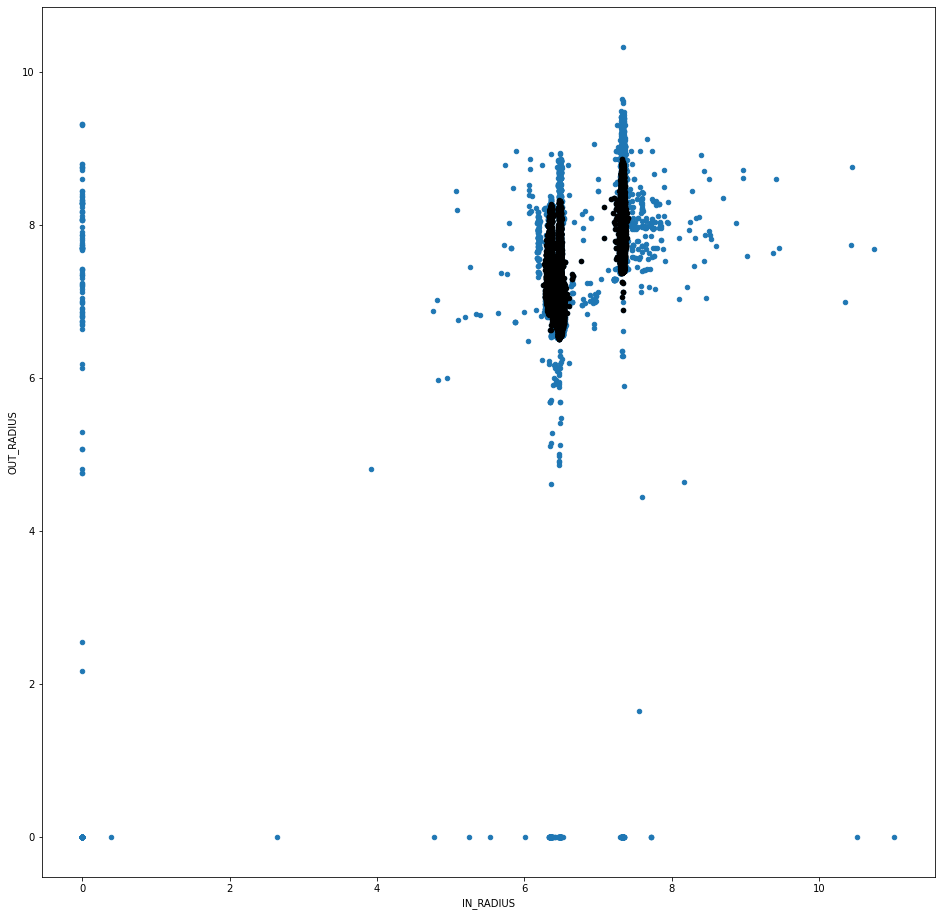

The shape of data after preprocessing: (26245, 18)



In [12]:
df_after = preprocessing_outlier(df_after)

## XGBoost 모델 학습

In [13]:
# Onehot encoder
ENCODER = None

# XGBoost
N_ESTIMATORS = 6000
ETA = 0.25
SUB_SAMPLE = 0.9

In [14]:
# 학습 및 평가 데이터셋 분리 함수

def prepare_data(df, numeric_cols, onehot_cols, y_col):
 x_cols = numeric_cols + onehot_cols

 df = df.dropna(
 axis=0,
 how= 'any',
 subset=x_cols+y_col
 ) 

 data_X = df[x_cols]
 data_y = df[y_col]

 print('\nSplitting data into train set and test set...')
 X_train, X_test, y_train, y_test = train_test_split(data_X,data_y,test_size=.3,random_state=42)

 print(f'The shape of X_train, y_train: X_train.shape, y_train.shape')
 print(f'The shape of X_test, y_test: X_test.shape, y_test.shape')

 bounds = df.groupby(['REAL_POWER'])[numeric_cols].agg(['min', 'max'])

 return X_train, X_test, y_train, y_test, bounds

In [15]:
# 원핫인코딩 함수

def transform_cols(df, encoder):
 if encoder is None:
   print('ENCODER fit_transform')
   encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
   onehot = encoder.fit_transform(df[EQUIP_INFO])
 else:
   print('ENCODER transform')
   onehot = encoder.transform(df[EQUIP_INFO])

 transformed_onehot_cols = encoder.get_feature_names(EQUIP_INFO).ravel().tolist()
 df = np.hstack((df[RADIUS].to_numpy(),onehot))
 df = pd.DataFrame(df, columns=RADIUS+transformed_onehot_cols)
 
 return df, encoder

In [16]:
# 학습 데이터와 평가 데이터 분리
# melt() : id_vars는 기준이 되는 컬럼 지정, value_vars는 녹여서 값과 같이 행으로 들어갈 컬럼

df_prep = df_after.reset_index().melt(
    id_vars = ["index", "SALE_CD", "REAL_POWER"] + RADIUS + EQUIP_INFO,
    value_vars = POWERS,
    value_name = 'y'
)

print(f"The shape of data which will be returned: {df_prep.shape}")

The shape of data which will be returned: (131225, 9)


In [17]:
df_prep

,index,SALE_CD,REAL_POWER,IN_RADIUS,OUT_RADIUS,EQUIP_ID,MOLD_POS,variable,y
0,0,SALES 1,-6.50,6.3564,7.4551,EQUIP2,1,POWER1,-6.25
1,1,SALES 3,-7.50,6.3600,7.6877,EQUIP2,6,POWER1,-7.50
2,2,SALES 4,-0.75,7.3411,7.5236,EQUIP3,1,POWER1,-0.87
3,3,SALES 5,-4.00,6.4829,7.1508,EQUIP4,8,POWER1,-4.00
4,4,SALES 6,-8.50,6.4800,8.2939,EQUIP5,6,POWER1,-8.25
...,...,...,...,...,...,...,...,...,...
131220,149358,SALES 114,-2.25,6.5197,6.8885,EQUIP12,4,POWER5,-2.25
131221,149360,SALES 114,-4.00,6.3326,6.9997,EQUIP37,1,POWER5,-4.00
131222,149361,SALES 114,-4.75,6.3279,7.0979,EQUIP37,8,POWER5,-4.75
131223,149362,SALES 114,-5.25,6.3304,7.1881,EQUIP13,4,POWER5,-5.25


In [18]:
X_train, X_test, y_train, y_test, bounds = prepare_data(
    df = df_prep,
    numeric_cols = RADIUS,
    onehot_cols = EQUIP_INFO,
    y_col = ['y']
)


Splitting data into train set and test set...
The shape of X_train, y_train: X_train.shape, y_train.shape
The shape of X_test, y_test: X_test.shape, y_test.shape


In [22]:
#if len(GPUtil.getGPUs())<1:
if True:
  regressor = xgboost.XGBRegressor(
      n_estimators = N_ESTIMATORS,
      objective = 'reg:squarederror',
      eta = ETA,
      tree_method = 'hist',
      gpu_id = 0,
      subsample = SUB_SAMPLE
  )
else:
  regressor = xgboost.XGBRegressor(
      n_estimators = N_ESTIMATORS,
      objective = 'reg:squarederror',
      eta = ETA,
      tree_method = 'gpu_hist',
      gpu_id = 0,
      subsample = SUB_SAMPLE
  )

In [20]:
# X_train과 X_test 열의 원핫 인코딩
X_train, ENCODER = transform_cols(X_train, ENCODER)
X_test, ENCODER = transform_cols(X_test, ENCODER)

ENCODER fit_transform
ENCODER transform


In [21]:
X_train.columns

Index(['IN_RADIUS', 'OUT_RADIUS', 'EQUIP_ID_EQUIP1', 'EQUIP_ID_EQUIP10',
       'EQUIP_ID_EQUIP11', 'EQUIP_ID_EQUIP12', 'EQUIP_ID_EQUIP13',
       'EQUIP_ID_EQUIP14', 'EQUIP_ID_EQUIP15', 'EQUIP_ID_EQUIP16',
       'EQUIP_ID_EQUIP17', 'EQUIP_ID_EQUIP18', 'EQUIP_ID_EQUIP19',
       'EQUIP_ID_EQUIP2', 'EQUIP_ID_EQUIP20', 'EQUIP_ID_EQUIP21',
       'EQUIP_ID_EQUIP25', 'EQUIP_ID_EQUIP26', 'EQUIP_ID_EQUIP27',
       'EQUIP_ID_EQUIP28', 'EQUIP_ID_EQUIP29', 'EQUIP_ID_EQUIP3',
       'EQUIP_ID_EQUIP31', 'EQUIP_ID_EQUIP32', 'EQUIP_ID_EQUIP33',
       'EQUIP_ID_EQUIP34', 'EQUIP_ID_EQUIP35', 'EQUIP_ID_EQUIP36',
       'EQUIP_ID_EQUIP37', 'EQUIP_ID_EQUIP38', 'EQUIP_ID_EQUIP4',
       'EQUIP_ID_EQUIP5', 'EQUIP_ID_EQUIP6', 'EQUIP_ID_EQUIP7',
       'EQUIP_ID_EQUIP8', 'EQUIP_ID_EQUIP9', 'MOLD_POS_1', 'MOLD_POS_2',
       'MOLD_POS_3', 'MOLD_POS_4', 'MOLD_POS_5', 'MOLD_POS_6', 'MOLD_POS_7',
       'MOLD_POS_8'],
      dtype='object')

In [23]:
history = regressor.fit(
    X = X_train,
    y = y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    eval_metric = 'mae',
    early_stopping_rounds = N_ESTIMATORS/10
)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[1000]	validation_0-mae:0.360184	validation_1-mae:0.36472
[1001]	validation_0-mae:0.360165	validation_1-mae:0.36472
[1002]	validation_0-mae:0.360098	validation_1-mae:0.364698
[1003]	validation_0-mae:0.359989	validation_1-mae:0.364581
[1004]	validation_0-mae:0.359852	validation_1-mae:0.36448
[1005]	validation_0-mae:0.35984	validation_1-mae:0.364461
[1006]	validation_0-mae:0.359786	validation_1-mae:0.364423
[1007]	validation_0-mae:0.359707	validation_1-mae:0.364353
[1008]	validation_0-mae:0.35978	validation_1-mae:0.364451
[1009]	validation_0-mae:0.359754	validation_1-mae:0.364443
[1010]	validation_0-mae:0.359692	validation_1-mae:0.364375
[1011]	validation_0-mae:0.359658	validation_1-mae:0.364338
[1012]	validation_0-mae:0.359628	validation_1-mae:0.364318
[1013]	validation_0-mae:0.359596	validation_1-mae:0.364289
[1014]	validation_0-mae:0.359575	validation_1-mae:0.364254
[1015]	validation_0-mae:0.359577	validation_1-mae:0.364254
[1016]	validation_0-mae:0

In [24]:
# score 확인
print(f"Score: train({regressor.score(X_train, y_train)}), test({regressor.score(X_test, y_test)})")

Score: train(0.9288020764678505), test(0.9179276958884603)


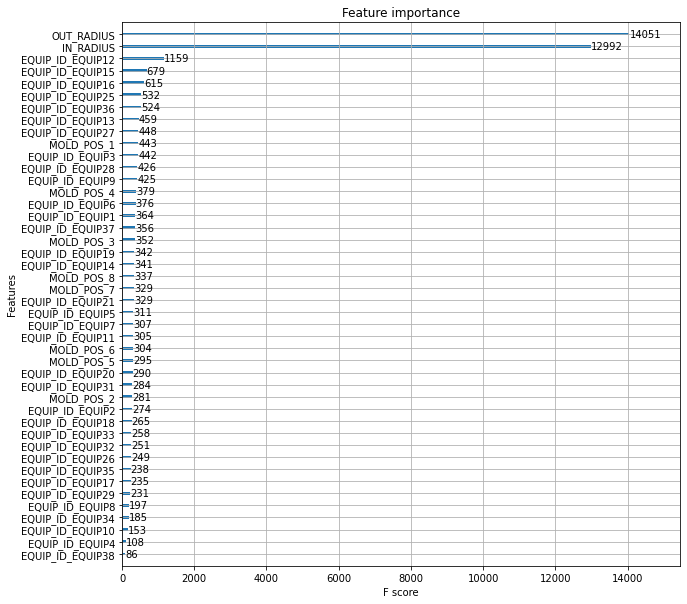

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(regressor, ax=ax)

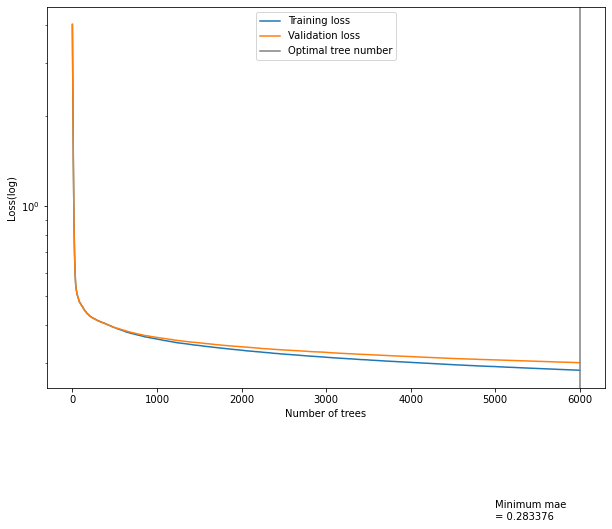

In [26]:
# 학습률 확인해보기
# 본 모델의 경우 n_estimator가 6000일 때 best_ntree_limit도 6000이 나왔기 때문에 n_estimator의 크기를 늘릴 경우 모델의 정확도가
# 더 높아진다고 판단할 수 있음, 하지만 모델의 스코어가 이미 0.99를 넘겼기 때문에 n_estimator를 늘릴 필요가 없다고 판단하여 보정 없이 학습된 모델 사용함!

xgb_val = regressor.evals_result()

plt.figure(figsize=(10,7))
plt.yscale('log')

plt.text(5000, 0.09, "Minimum mae \n= "+str(min(xgb_val["validation_0"]["mae"])))
plt.plot(xgb_val["validation_0"]["mae"], label= 'Training loss')
plt.plot(xgb_val["validation_1"]["mae"], label= 'Validation loss')
plt.axvline(regressor.best_ntree_limit, color= 'gray', label= 'Optimal tree number')

plt.xlabel('Number of trees')
plt.ylabel('Loss(log)')
plt.legend()
plt.show()

In [27]:
# 결과를 담을 데이터프레임 생성
cols_result = EQUIP_INFO+CORES+RADIUS+['RANK_INDEX','RANK_INDEX_1','RANK_INDEX_2','PREDICTED_POWER',
'PREDICTED_POWER2','ERROR']

df_result = pd.DataFrame(columns=cols_result)
df_result = df_result.astype(
 {
 'IN_RADIUS':'float',
 'OUT_RADIUS':'float',
 'RANK_INDEX':'float',
 'RANK_INDEX_1':'float',
 'RANK_INDEX_2':'float',
 'PREDICTED_POWER':'float',
 'PREDICTED_POWER2':'float',
 'ERROR':'float'
 }
)

df_result.dtypes

EQUIP_ID             object
MOLD_POS             object
MOLD_IN_TOP          object
MOLD_IN_BOT          object
MOLD_OUT_TOP         object
MOLD_OUT_BOT         object
IN_RADIUS           float64
OUT_RADIUS          float64
RANK_INDEX          float64
RANK_INDEX_1        float64
RANK_INDEX_2        float64
PREDICTED_POWER     float64
PREDICTED_POWER2    float64
ERROR               float64
dtype: object

In [28]:
# 입력조건 샘플 목록

df_sample = df_raw.groupby(['CATEGORY']+EQUIP_INFO+['REAL_POWER','MOLD_IN_TOP']).count().reset_index()
df_sample = df_sample[df_sample['POWER1'] > 10].sort_values(by=['POWER1'], ascending=False)
df_sample = df_sample[df_sample['CATEGORY']=='MYOPIA']
df_sample.reset_index(drop=True, inplace=True)
df_sample.iloc[0:10]

,CATEGORY,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MFG_DT,SALE_CD,CP,AX,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5
0,MYOPIA,EQUIP4,5,-1.75,CORE1 A 02. 0570,77,77,0,0,77,77,77,77,77,77,77,77,77,77,77
1,MYOPIA,EQUIP4,1,-1.50,CORE1 A 02. 0570,71,71,0,0,71,71,71,71,71,71,71,71,71,71,71
2,MYOPIA,EQUIP25,3,-1.50,CORE1 A 02. 0570,66,66,0,0,66,66,66,66,66,66,66,66,66,66,66
3,MYOPIA,EQUIP4,2,-1.50,CORE1 A 02. 0570,65,65,0,0,65,65,65,65,65,65,65,65,65,65,65
4,MYOPIA,EQUIP4,7,-2.00,CORE1 A 02. 0570,65,65,0,0,65,65,65,65,65,65,65,65,65,65,65
5,MYOPIA,EQUIP25,1,-1.75,CORE1 A 02. 0570,64,64,0,0,64,64,64,64,64,64,64,64,64,64,64
6,MYOPIA,EQUIP4,6,-2.00,CORE1 A 02. 0570,61,61,0,0,61,61,61,61,61,60,60,60,60,60,60
7,MYOPIA,EQUIP25,1,-2.50,CORE1 A 02. 0570,60,60,0,0,60,60,60,60,60,60,60,60,60,60,60
8,MYOPIA,EQUIP31,6,-3.25,CORE1 A 02. 0570,60,60,0,0,60,60,60,60,60,60,60,60,60,60,60
9,MYOPIA,EQUIP18,2,-4.00,CORE1 B 02. 0550,59,59,0,0,59,59,59,59,59,59,59,59,59,59,59


In [29]:
idx_sample = input("샘플데이터 중 원하는 데이터의 인덱스를 입력해주세요:")
idx_sample = int(idx_sample)

equipment_id = df_sample.iloc[idx_sample]['EQUIP_ID']
mold_position = df_sample.iloc[idx_sample]['MOLD_POS']
mold_position = int(mold_position)
target_power = df_sample.iloc[idx_sample]['REAL_POWER']
target_power = float(target_power)
core_group = df_sample.iloc[idx_sample]['MOLD_IN_TOP'][:-9]

# 선택한 조건 확인 출력
print(f'equipment_id: {equipment_id}, \
 mold_position: {mold_position}, \
 target_power: {target_power}, \
 core_group: {core_group}')

if target_power < 0:
 category ="MYOPIA"
elif target_power == 0:
 category ="BEAUTY"
else:
 category ="HYPER"

샘플데이터 중 원하는 데이터의 인덱스를 입력해주세요:0
equipment_id: EQUIP4,  mold_position: 5,  target_power: -1.75,  core_group: CORE1 A


## 연관규칙 알고리즘을 통한 금형조합 묶음

- 입력조건을 만족하면서 동일한 금형군에 속한 금형조합의 평균 IN_RADIUS와 OUT_RADIUS를 구함.

In [30]:
df_pre_assoc = df_raw.copy()

df_pre_assoc = df_pre_assoc[df_pre_assoc["MOLD_IN_TOP"].str.contains(core_group)]

for name in CORES:
 df_pre_assoc[name] = df_pre_assoc[name].str.replace(" ", "_")

print(df_pre_assoc[CORES][:5])

         MOLD_IN_TOP       MOLD_IN_BOT       MOLD_OUT_TOP      MOLD_OUT_BOT
5   CORE1_A_02._0570  CORE1_A_01._P1+2  CORE1_A_05._M0650  CORE1_A_08._C-06
6   CORE1_A_02._0570  CORE1_A_01._P3+2  CORE1_A_05._M1550  CORE1_A_08._C-15
7   CORE1_A_02._0570  CORE1_A_01._P3+3  CORE1_A_05._M0500  CORE1_A_08._A-05
9   CORE1_A_02._0570  CORE1_A_01._P3+2  CORE1_A_05._M0400  CORE1_A_08._A-04
10  CORE1_A_02._0570  CORE1_A_01._P3+1  CORE1_A_05._M0925  CORE1_A_08._B-09


In [31]:
df_pre_assoc = pd.get_dummies(df_pre_assoc, columns=CORES)
print(df_pre_assoc.columns[16:], df_pre_assoc.shape)

Index(['MOLD_IN_TOP_CORE1_A_02._0570', 'MOLD_IN_BOT_CORE1_A_01._M1+0',
       'MOLD_IN_BOT_CORE1_A_01._M1+1', 'MOLD_IN_BOT_CORE1_A_01._M1+2',
       'MOLD_IN_BOT_CORE1_A_01._M1+3', 'MOLD_IN_BOT_CORE1_A_01._M1-1',
       'MOLD_IN_BOT_CORE1_A_01._M2+0', 'MOLD_IN_BOT_CORE1_A_01._M2+1',
       'MOLD_IN_BOT_CORE1_A_01._M2+3', 'MOLD_IN_BOT_CORE1_A_01._M2-1',
       ...
       'MOLD_OUT_BOT_CORE6_A_07._C-16', 'MOLD_OUT_BOT_CORE6_A_07._D-00',
       'MOLD_OUT_BOT_CORE6_A_07._D-01', 'MOLD_OUT_BOT_CORE6_A_07._D-02',
       'MOLD_OUT_BOT_CORE6_A_07._D-03', 'MOLD_OUT_BOT_CORE6_A_07._D-04',
       'MOLD_OUT_BOT_CORE6_A_07._D-05', 'MOLD_OUT_BOT_CORE6_A_07._D-06',
       'MOLD_OUT_BOT_CORE6_A_07._D-07', 'MOLD_OUT_BOT_CORE6_A_07._D-08'],
      dtype='object', length=362) (56352, 378)


In [32]:
df_assoc = df_pre_assoc.copy()
assoc_pos = mold_position

df_assoc = df_assoc[(df_assoc['CATEGORY']==category) &
 (df_assoc['EQUIP_ID']==equipment_id) &
 (df_assoc['MOLD_POS']==mold_position) &
 (df_assoc['REAL_POWER']==target_power)]

In [34]:
if df_assoc.shape[0] == 0:
  print(f'No history, Searching within All')
  df_assoc = df_pre_assoc.copy()
  df_assoc = df_assoc[(df_assoc['CATEGORY']==category) & (df_assoc['REAL_POWER']==target_power)]
  assoc_pos = 0

In [37]:
df_ = df_assoc.copy()
df_ex = df_.iloc[:,16:].replace(1,True).replace(0,False)
print(df_ex.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 2954 to 172496
Data columns (total 362 columns):
 #    Column                          Dtype
---   ------                          -----
 0    MOLD_IN_TOP_CORE1_A_02._0570    bool 
 1    MOLD_IN_BOT_CORE1_A_01._M1+0    bool 
 2    MOLD_IN_BOT_CORE1_A_01._M1+1    bool 
 3    MOLD_IN_BOT_CORE1_A_01._M1+2    bool 
 4    MOLD_IN_BOT_CORE1_A_01._M1+3    bool 
 5    MOLD_IN_BOT_CORE1_A_01._M1-1    bool 
 6    MOLD_IN_BOT_CORE1_A_01._M2+0    bool 
 7    MOLD_IN_BOT_CORE1_A_01._M2+1    bool 
 8    MOLD_IN_BOT_CORE1_A_01._M2+3    bool 
 9    MOLD_IN_BOT_CORE1_A_01._M2-1    bool 
 10   MOLD_IN_BOT_CORE1_A_01._OK+0    bool 
 11   MOLD_IN_BOT_CORE1_A_01._OK+1    bool 
 12   MOLD_IN_BOT_CORE1_A_01._OK+2    bool 
 13   MOLD_IN_BOT_CORE1_A_01._OK+3    bool 
 14   MOLD_IN_BOT_CORE1_A_01._OK+4    bool 
 15   MOLD_IN_BOT_CORE1_A_01._OK-1    bool 
 16   MOLD_IN_BOT_CORE1_A_01._P1+0    bool 
 17   MOLD_IN_BOT_CORE1_A_01._P1+1    bool 
 18   MOL

In [38]:
assoc_result = fpgrowth(df_ex, min_support=0.005, use_colnames=True)

# 연관규칙 도출 결과 중 ["sets"]==4인 경우,
# 즉 4개의 금형이 조합을 이루는 유효한 값을 추려냄
assoc_result["sets"] = assoc_result["itemsets"].apply(lambda x: len(x))
print(assoc_result.sort_values(by=["sets"], ascending=False))
assoc_result = assoc_result[assoc_result["sets"]==4]
print(assoc_result)

      support                                           itemsets  sets
176  0.012987  (MOLD_IN_BOT_CORE1_A_01._P2+1, MOLD_OUT_BOT_CO...     4
107  0.012987  (MOLD_IN_BOT_CORE1_A_01._P3+2, MOLD_OUT_TOP_CO...     4
151  0.012987  (MOLD_OUT_BOT_CORE1_A_05._A-03, MOLD_IN_TOP_CO...     4
69   0.012987  (MOLD_IN_BOT_CORE1_A_01._P2+2, MOLD_OUT_BOT_CO...     4
33   0.376623  (MOLD_OUT_TOP_CORE1_A_05._M0325, MOLD_IN_TOP_C...     4
..        ...                                                ...   ...
19   0.038961                     (MOLD_IN_BOT_CORE1_A_01._P3+3)     1
20   0.038961                    (MOLD_OUT_BOT_CORE1_A_8A._D-02)     1
22   0.012987                     (MOLD_IN_BOT_CORE1_A_01._P2+1)     1
1    0.480519                     (MOLD_IN_BOT_CORE1_A_01._P1+2)     1
0    1.000000                     (MOLD_IN_TOP_CORE1_A_02._0570)     1

[177 rows x 3 columns]
      support                                           itemsets  sets
33   0.376623  (MOLD_OUT_TOP_CORE1_A_05._M0325, MOLD_

In [40]:
# 데이터셋의 컬럼명을 원래의 형태로 복원
temp_df = pd.DataFrame(columns=CORES+["SUPPORT"])
temp_list = [list(x) for x in assoc_result["itemsets"]]

for i, dset in enumerate(temp_list):
 for name in dset:
  if "MOLD_IN_TOP_" in name:
    p1 = compile("MOLD_IN_TOP_{ }")
    mold_in_top = p1.parse(name)[0]
  elif "MOLD_IN_BOT_" in name:
    p2 = compile("MOLD_IN_BOT_{ }")
    mold_in_bot = p2.parse(name)[0]
  elif "MOLD_OUT_TOP_" in name:
    p3 = compile("MOLD_OUT_TOP_{ }")
    mold_out_top = p3.parse(name)[0]
  elif "MOLD_OUT_BOT_" in name:
    p4 = compile("MOLD_OUT_BOT_{ }")
    mold_out_bot = p4.parse(name)[0] 
  score = assoc_result["support"].iloc[i]

 temp_df.loc[i] = [mold_in_top, mold_in_bot, mold_out_top, mold_out_bot, score]
 temp_df = temp_df.sort_values(by="SUPPORT", ascending=False)

assoc_result = temp_df

# 금형이름에서 "_"를 " "로 변환
for name in CORES:
 assoc_result[name] = assoc_result[name].str.replace("_", " ")
print(assoc_result)

TypeError: ignored

In [ ]:
df_temp_raw = df_raw.copy()
if assoc_pos != 0:
 df_temp_raw = df_temp_raw[(df_temp_raw["EQUIP_ID"]==equipment_id) & (df_temp_raw["MOLD_POS"]==assoc_pos)]

In [ ]:
df_temp_result = pd.DataFrame(columns=df_temp_raw.columns)
df_temp_result = df_temp_result.astype(
 {
 'REAL_POWER':'float',
 'IN_RADIUS':'float',
 'OUT_RADIUS':'float',
 'POWER':'float',
 'POWER1':'float',
 'POWER2':'float',
 'POWER3':'float',
 'POWER4':'float',
 'POWER5':'float'
 }
)

In [ ]:
for i in range(assoc_result.shape[0]):
 # 연관규칙 결과와 일치하는 결과를 모두 찾기
 mold_in_top = assoc_result.loc[i,]["MOLD_IN_TOP"]
 mold_in_bot = assoc_result.loc[i,]["MOLD_IN_BOT"]
 mold_out_top = assoc_result.loc[i,]["MOLD_OUT_TOP"]
 mold_out_bot = assoc_result.loc[i,]["MOLD_OUT_BOT"]
 
 df_temp = df_temp_raw[(df_temp_raw["MOLD_IN_TOP"]==mold_in_top) & \
 (df_temp_raw["MOLD_IN_BOT"]==mold_in_bot) & \
 (df_temp_raw["MOLD_OUT_TOP"]==mold_out_top) & \
 (df_temp_raw["MOLD_OUT_BOT"]==mold_out_bot)
 ]
 df_temp_result = pd.concat([df_temp_result, df_temp])
 
# 중복 데이터 제거
df_temp_result = df_temp_result.drop(["MFG_DT","SALE_CD","REAL_POWER","POWER","CATEGORY"], axis=1)
df_temp_result = df_temp_result[EQUIP_INFO+CORES+RADIUS+POWERS]
df_temp_result = df_temp_result.drop_duplicates(CORES+RADIUS)
df_temp_result.reset_index(inplace=True, drop=True)

In [ ]:
tmp = df_temp_result.melt(
 id_vars=EQUIP_INFO+CORES,
 value_vars=POWERS,
 value_name="P"
).astype({"P":"float"})
tmp

In [ ]:
tmp = tmp.groupby(
 EQUIP_INFO+CORES,
 as_index=False,
 sort=False
).median()

In [ ]:
df_temp_result = df_temp_result.groupby(
 EQUIP_INFO+CORES,
 as_index=False,
 sort=False
).median()
df_result = pd.concat([df_result, df_temp_result])

In [ ]:
df_result['RANK_INDEX_1'] = np.abs(tmp['P'].values - target_power)
df_result

In [ ]:
if df_result.shape[0]==0:
 print("입력조건과 일치하는 생산이력이 존재하지 않습니다.")

## 연관규칙 결과와 XGBoost 예측결과에서 최적조건 찾기

In [ ]:
# POWER 할당 함수

POWER_VALUES = np.array([-0.25, -0.5, -0.75,
 -1.0, -1.25, -1.5, -1.75,
 -2.0, -2.25, -2.5, -2.75,
 -3.0, -3.25, -3.5, -3.75,
 -4.0, -4.25, -4.5, -4.75,
 -5.0, -5.25, -5.5, -5.75,
 -6.0, -6.5,
 -7.0, -7.5,
 -8.0, -8.5,
 -9.0, -9.5,
 -10.0])

def power_allocate(value):
 return POWER_VALUES[np.argmin(abs(POWER_VALUES - value))]
 
def vectorize(value):
 return np.vectorize(power_allocate)(value)

In [ ]:
# XGBoost Regressor를 이용한 도수 예측
df_result[RADIUS] = abs(df_result[RADIUS])

X = df_result[RADIUS+EQUIP_INFO]
X.loc[:, "EQUIP_ID"] = equipment_id
X.loc[:, "MOLD_POS"] = mold_position

X, ENCODER = transform_cols(X, ENCODER)

In [ ]:
df_result['PREDICTED_POWER'] = regressor.predict(X)
df_result['PREDICTED_POWER2'] = df_result['PREDICTED_POWER'].apply(vectorize)

In [ ]:
df_result['RANK_INDEX_2'] = np.abs(df_result['PREDICTED_POWER'].values - target_power)

if all(df_result['EQUIP_ID'] == equipment_id) & all(df_result['MOLD_POS'] == mold_position):
 df_result['RANK_INDEX'] = df_result['RANK_INDEX_1'] + df_result['RANK_INDEX_2']
else:
 df_result['RANK_INDEX'] = df_result['RANK_INDEX_2']

df_result = df_result.sort_values(by='RANK_INDEX').iloc[:5] # 5개까지
df_result['EQUIP_ID'] = equipment_id
df_result['MOLD_POS'] = mold_position

In [ ]:
df_result["ERROR"] = df_result["PREDICTED_POWER2"] - target_power